# Lab 4: Building an AI Agent with Langgraph

## LangGraph 
Langgraph is a low-level orchestration framework for building controllable agents. While langchain provides integrations and composable components to streamline LLM application development, the LangGraph library enables **agent orchestration** — offering customizable architectures, long-term memory, and human-in-the-loop to reliably handle complex tasks.

## Initiation

In [1]:
# Installing langgraph package
!pip install langgraph 


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# loading environment variables 
from dotenv import load_dotenv
load_dotenv(override=True)  # take environment variables

True

## Learning about Graph

Let's examine the simplest form of a graph as used in LangGraph. <br /><br />
<img src="./assets/simple graph.png" width="450">

A LangGraph graph is composed of the following components:
1. State: The state represents the shared memory or context that flows through the graph. It is typically a structured data object (e.g., a dictionary or class) that holds intermediate inputs, outputs, and metadata across the graph's execution. The state is updated as it moves from node to node.

2. Node: A node represents a unit of computation — usually a function, language model call, or tool execution. Each node operates on the incoming state, performs some processing, and returns an updated state. Nodes are the core logic blocks in LangGraph.

3. Edge: An edge defines the transition between nodes. It determines which node to execute next based on the current state or the output of the previous node. Edges can be static (predefined paths) or dynamic (based on conditions or branching logic), enabling flexible and adaptive workflows.

### State, Nodes, and Edges

In [ ]:
# State
from typing import TypedDict, Literal

class State(TypedDict):
    user_selection: str
    graph_state: str

# Nodes
# Nodes are just python functions. Each node operates on the state.
# Langgraph has 2 special nodes, called START node and END, to denote the start and the end of a graph.

def node1(state):
    print("---Inside Node No 1---")
    return {'graph_state': state['graph_state'] + "Passing through Node 1. | "}

def node2(state):
    print("---Inside Node No 2---")
    return {'graph_state': state['graph_state'] + "Passing through Node 2. | "}

def node3(state):
    print("---Inside Node No 3---")
    return {'graph_state': state['graph_state'] + "Passing through Node 3. | "}

# Edges
# 2 types of edges: normal edges vs conditional edges
# Normal edges will be defined directly when we build the graph using langgraph
# Conditional edges require a function to define the conditions
# Here we will define an example of conditional edges

def decide_your_way(state) -> Literal["Node2", "Node3"]:
    user_selection = state['user_selection']

    if user_selection == "Node 2":
        return "Node2"
    else:
        return "Node3"
 

### Graph Construction
Let's connect those nodes into a graph using StateGraph from LangGraph.

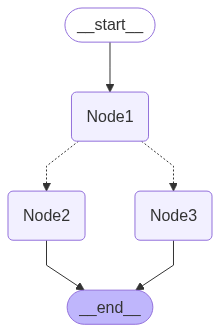

In [22]:
from langgraph.graph import StateGraph, START, END

# Build the nodes
builder = StateGraph(State)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)
builder.add_node("Node3", node3)

# Connect Edges
builder.add_edge(START, "Node1")
builder.add_conditional_edges("Node1", decide_your_way)
builder.add_edge("Node2", END)
builder.add_edge("Node3", END)

# Compile graph
graph = builder.compile()

# View
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))



### Graph Invocation

In [23]:
# Graph invocation
user_input = input("Decide which way you want to go (Node 2 or Node 3): ")
graph.invoke({'user_selection': user_input, 'graph_state': "START | "})

---Inside Node No 1---
---Inside Node 3---


{'user_selection': 'Node 3',
 'graph_state': 'START | Passing through Node 1. | Passing through Node 3. | '}

## State Schema

When you initiate a builder in LangGraph, you need to provide the schema of the graph's state to the StateGraph class. This schema defines the structure and data types of the state. Previously, the schema was created using the TypedDict class, but it can also be defined using Python's dataclass or the Pydantic library. Using Pydantic allows you to enforce type validation, offering better protection for the state's parameters.

In [33]:
# Previous schema, but we put limitation on user_selection parameter to only valid for 2 values only
class TypedDictState(TypedDict):
    user_selection: Literal["Node 2", "Node 3"]
    graph_state: str

# modify the conditional node 
def choose_paths(state):
    user_selection = state['user_selection']

    if user_selection == "Node 2":
        return "Node2"
    elif user_selection == "Node 3":
        return "Node3"
    else: 
        return END

# Build the nodes
builder = StateGraph(TypedDictState)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)
builder.add_node("Node3", node3)

# Connect Edges
builder.add_edge(START, "Node1")
builder.add_conditional_edges("Node1", choose_paths)
builder.add_edge("Node2", END)
builder.add_edge("Node3", END)

# Compile graph
graph2 = builder.compile()

In [32]:
user_input = input("Decide which way you want to go (Node 2 or Node 3): ")
graph2.invoke({'user_selection': user_input, 'graph_state': "START | "})

---Inside Node No 1---


{'user_selection': 'buki', 'graph_state': 'START | Passing through Node 1. | '}

In [49]:
## Pydantic
from langchain_core.pydantic_v1 import BaseModel, ValidationError

class PydanticState(BaseModel):
    user_selection: Literal["Node 2", "Node 3"]
    graph_state: str

In [ ]:
# PydanticState(user_selection="Node 4", graph_state=3) 
# PydanticState(user_selection="Node 2", graph_state=3)

PydanticState(user_selection='Node 2', graph_state='3')

In [61]:
a = PydanticState(user_selection="Node 2", graph_state="fi") 
a.graph_state

'fi'

In [62]:
# Build the nodes
def node1(state):
    print("---Inside Node No 1---")
    return {'graph_state': state.graph_state + "Passing through Node 1. | "}

def node2(state):
    print("---Inside Node No 2---")
    return {'graph_state': state.graph_state + "Passing through Node 2. | "}

def node3(state):
    print("---Inside Node No 3---")
    return {'graph_state': state.graph_state + "Passing through Node 3. | "}

def choose_paths(state):
    user_selection = state.user_selection

    if user_selection == "Node 2":
        return "Node2"
    elif user_selection == "Node 3":
        return "Node3"
    else: 
        return END
    
builder = StateGraph(PydanticState)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)
builder.add_node("Node3", node3)

# Connect Edges
builder.add_edge(START, "Node1")
builder.add_conditional_edges("Node1", choose_paths)
builder.add_edge("Node2", END)
builder.add_edge("Node3", END)

# Compile graph
graph3 = builder.compile()

In [77]:
user_input = input("Decide which way you want to go (Node 2 or Node 3): ")

graph_state = None
try: 
    graph_state = graph3.invoke({'user_selection': user_input, 'graph_state': "START | "})
except ValidationError as e:
    print(e)

print(graph_state)

1 validation error for PydanticState
user_selection
  unexpected value; permitted: 'Node 2', 'Node 3' (type=value_error.const; given=hey; permitted=('Node 2', 'Node 3'))
None


## Message Reducers

In [ ]:
# MessagesState 
# Built-in state for working with messages 

from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph.message import add_messages

# Append Messages into the state
initial_state = [AIMessage(content="Hello, How can I help you?", name = "GPT"),
                 HumanMessage(content="I'm learning about generative AI, please explain about it.", name = "Hizkia")
                 ]

new_message = AIMessage(content="Sure, I can help you with that. Here is a brief explanation about generative AI. Generative AI is.... ", name = "GPT4")

# append
add_messages(initial_state, new_message)

# the MessagesState Class has embedded add_messages function so a new message will be automatically appended into the state.

[AIMessage(content='Hello, How can I help you?', additional_kwargs={}, response_metadata={}, name='GPT', id='b9449100-54fc-4adf-a6b9-5db7baabc7df'),
 HumanMessage(content="I'm learning about generative AI, please explain about it.", additional_kwargs={}, response_metadata={}, name='Hizkia', id='d4e424b3-94e3-4612-82ed-d5bb4e10b9c5'),
 AIMessage(content='Sure, I can help you with that. Here is a brief explanation about generative AI. Generative AI is.... ', additional_kwargs={}, response_metadata={}, name='GPT4', id='b5451bc3-14db-4c2a-b3b3-04f7166dbbc2')]

In [79]:
# Rewriting Messages 
# use id 

initial_state = [AIMessage(content="Hello, How can I help you?", name = "GPT", id = 1),
                 HumanMessage(content="I'm learning about generative AI, please explain about it.", name = "Hizkia", id = 2)
                 ]

new_message = HumanMessage(content="I am looking for definition of agentic AI.", name = "GPT4", id = 2)

add_messages(initial_state, new_message)

[AIMessage(content='Hello, How can I help you?', additional_kwargs={}, response_metadata={}, name='GPT', id='1'),
 HumanMessage(content='I am looking for definition of agentic AI.', additional_kwargs={}, response_metadata={}, name='GPT4', id='2')]

In [80]:
# Deleting Messages 

from langchain_core.messages import RemoveMessage

# Message List 
messages = [AIMessage(content="Hi, My name is ChatGPT. How may I help you?", name="Bot", id=1)]
messages.append(HumanMessage(content="Hi.", name="Hizkia", id=2))
messages.append(AIMessage(content="So you said you were looking for information on agentic AI?", name="Bot", id=3))
messages.append(HumanMessage(content="Yes, can u provide the brief definition of the term agentic AI?", name="Bot", id=4))

# Delete all but the 2 most recent messages
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [81]:
add_messages(messages, delete_messages)

[AIMessage(content='So you said you were looking for information on agentic AI?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, can u provide the brief definition of the term agentic AI?', additional_kwargs={}, response_metadata={}, name='Bot', id='4')]

## MessagesState as a state

In [82]:
# Initiating Langchain Chat Models
from langchain.chat_models import init_chat_model
model = init_chat_model("gpt-4.1-mini", model_provider= "openai")

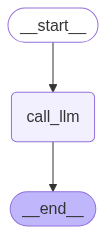

In [83]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node to invoke an LLM
def call_llm(state: MessagesState):
    return {"messages": model.invoke(state['messages'])}

# build the graph 
builder = StateGraph(MessagesState)
builder.add_node("call_llm", call_llm)

builder.add_edge(START, "call_llm")
builder.add_edge("call_llm", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [84]:
# 
output = graph.invoke({'messages': HumanMessage(content="Hi", name = "Hizkia")})

for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Hizkia

Hi
================================== Ai Message ==================================

Hello! How can I assist you today?


In [ ]:
output = graph.invoke({'messages': HumanMessage(content="Can you explain about agentic AI?", name = "Hizkia")})

for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Hizkia

Can you explain about agentic AI?
================================== Ai Message ==================================

Certainly! **Agentic AI** refers to artificial intelligence systems designed with some level of agency — meaning they can perceive their environment, make decisions, and take actions autonomously to achieve specific goals. Unlike simple automated tools that follow fixed instructions, agentic AI can:

- **Sense and interpret data:** It gathers information from its surroundings or inputs.
- **Reason and plan:** It evaluates options, predicts outcomes, and formulates strategies.
- **Act independently:** It takes actions without constant human intervention, adapting to changes and unforeseen circumstances.

### Key Characteristics of Agentic AI:
1. **Autonomy:** Operates on its own within defined boundaries.
2. **Goal-oriented behavior:** Works toward achieving explicit objectives.


## Chaining
Let us recreate prompt chaining that we did in Lab 1b, now using Langgraph, instead of using Langchain.

In [112]:
# Here the graph receives an input text, and generates 3 questions and answers based on the input text.

from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

input_text = """
Artificial Intelligence (AI) is transforming industries by enabling machines to learn from data, 
make decisions, and even improve over time. Applications range from chatbots and virtual assistants 
to complex data analytics and autonomous vehicles. However, AI also brings challenges such as ethical concerns, 
bias in algorithms, and job displacement. As AI continues to evolve, balancing innovation with responsible 
development will be key to its long-term success.
"""

# The first node in the chain
def summarize(state: MessagesState):
    """
        This tool is called when the user instructs assistant to summarize the passage. Make sure the passage is given by the user before calling this tool. 
        Ask the user to provide the passage first if you do not find the passage in the conversation. 

        Receiving the state of the graph as input.
    """
    prompt = [
        SystemMessage(content="Summarize the following passage from the user.")
    ] +  state['messages']

    response = model.invoke(prompt)

    return {'messages': AIMessage(content=response.content, name="Bot", id=response.id)}

# The second node in the chain
def generate_questions(state: MessagesState):
    """ 
        This tool is called to generate 3 questions related to a passage. Make sure the passage is given by the user before calling this tool. 
        Ask the user to provide the passage first if you do not find the passage in the conversation. 

        Receiving the state of the graph as input.
    """
    prompt = [
        SystemMessage(content="Create 3 questions from the passage that the user provides.")
    ] + state['messages']

    response = model.invoke(prompt)

    return {'messages': AIMessage(content=response.content, name="Bot")}

# The third node in the chain 
def answer_questions(state: MessagesState):
    """ 
        This tool is usually called right after the generate_questions tool. Make sure the passage is given by the user before calling this tool. 
        Ask the user to provide the passage first if you do not find the passage in the conversation. 

        Receiving the state of the graph as input.
    """
    prompt = [
        SystemMessage(content="Answer all questions that you previously created based on the passage that the user provides. Format your response in pairs of Question and Answers")
    ] + state['messages']

    response = model.invoke(prompt)

    return {'messages': AIMessage(content=response.content, name="Bot")}

builder = StateGraph(MessagesState)
builder.add_node("summarize_node", summarize)
builder.add_node("generate_question_node", generate_questions)
builder.add_node("answer_question_node", answer_questions)
builder.add_edge(START, "summarize_node")
builder.add_edge("summarize_node", "generate_question_node")
builder.add_edge("generate_question_node", "answer_question_node")
builder.add_edge("answer_question_node", END)
graph = builder.compile()

# user prompt
prompt = HumanMessage(content=input_text, name="Hizkia")
graph_output = graph.invoke({"messages": prompt})

In [106]:
graph_output['messages'][-1].content

"1. What are some common applications of Artificial Intelligence mentioned in the passage?  \nAnswer: The passage mentions chatbots, virtual assistants, complex data analytics, and autonomous vehicles as common applications of Artificial Intelligence.\n\n2. What challenges associated with AI are highlighted in the text?  \nAnswer: The passage highlights ethical concerns, bias in algorithms, and job displacement as the main challenges associated with AI.\n\n3. Why is balancing innovation with responsible development important for AI's future?  \nAnswer: Balancing innovation with responsible development is important for AI's long-term success, as it helps to address the challenges and ensures that AI evolves in a way that benefits society responsibly."

In [107]:
for m in graph_output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Hizkia


Artificial Intelligence (AI) is transforming industries by enabling machines to learn from data, 
make decisions, and even improve over time. Applications range from chatbots and virtual assistants 
to complex data analytics and autonomous vehicles. However, AI also brings challenges such as ethical concerns, 
bias in algorithms, and job displacement. As AI continues to evolve, balancing innovation with responsible 
development will be key to its long-term success.

================================== Ai Message ==================================
Name: Bot

Artificial Intelligence (AI) is revolutionizing various industries by allowing machines to learn, make decisions, and improve continuously. Its applications include chatbots, virtual assistants, data analytics, and autonomous vehicles. Despite its benefits, AI poses challenges like ethical issues, algorithmic bias, and job displacement. Ac

## Agents with Tools

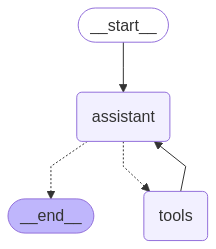

In [113]:
# Create tools 
tools = [summarize, generate_questions, answer_questions]
model_with_tools = model.bind_tools(tools)

# Create Assistant Node

def assistant(state: MessagesState):

    sys_msg = SystemMessage(content="You are a helpful assistant who communicates with the user and decide what the user intends to do. \n" \
                            "When the user says greeting, reponds the greeting politely and introduce yourself as Dexa Smart Assistant.\n" \
                            "When the user instructs you to summarize a passage, ask user to give the passage first, then call the summarize tool.\n" \
                            "When the user asks you to generate questions, ask the user to give you the passage, then call the generate_questions and answer_questions tools sequentially" \
                            "When the passage exists in the chat history, directly call the tools.")
    
    return {'messages': [model_with_tools.invoke([sys_msg] + state['messages'])]}

# Build the graph 
from langgraph.prebuilt import ToolNode, tools_condition
builder = StateGraph(MessagesState)

# Define nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges 
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show graph 
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
##
# graph_output = react_graph.invoke({'messages': HumanMessage(content="Hi, good morning.")})
# graph_output = react_graph.invoke({'messages': HumanMessage(content="Help me summarize a passage.")})
# graph_output = react_graph.invoke({'messages': HumanMessage(content=input_text)})
graph_output = react_graph.invoke({'messages': HumanMessage(content="I want to summarize the passage.")})
graph_output

### 
# In the end the assistant does not call any tool because it does not remember the whole conversation. Let's add a memory to the graph so it remembers the conversation

{'messages': [HumanMessage(content='I want to summarize the passage.', additional_kwargs={}, response_metadata={}, id='566e958a-77dc-4e19-94ff-5cecba83d33f'),
  AIMessage(content='Sure! Please provide the passage you want me to summarize.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 9149, 'total_tokens': 9163, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 9088}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_79b79be41f', 'id': 'chatcmpl-BWQFDju86EvwwklcbiJ5hJwWx2BeK', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--93c9e336-12b2-4314-8e05-8ee9c856be9a-0', usage_metadata={'input_tokens': 9149, 'output_tokens': 14, 'total_tokens': 9163, 'input_token_details': {'audio': 0, 'cache_read': 9088}, 'output_token_details

## Memory

In [120]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

react_graph_memory = builder.compile(checkpointer=memory)

In [ ]:
# specify a thread 
config = {"configurable": {"thread_id" : "1"}}

# specify an input 
messages = HumanMessage(content="Hi, good afternoon.")
# messages = HumanMessage(content="Help me summarize a passage.")
# messages = HumanMessage(content=input_text) 
# messages = HumanMessage(content="Great! Now can u generate quesions out of it?")
# messages = HumanMessage(content="you can use the previous passage.") 
# messages = HumanMessage(content="Now, provide also the answer to those questions.")

# Run 
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']: 
    m.pretty_print()


================================ Human Message =================================

Hi, good afternoon.
================================== Ai Message ==================================

Good afternoon! I am Dexa Smart Assistant. How may I assist you today?
================================ Human Message =================================

Help me summarize a passage.
================================== Ai Message ==================================

Sure, please provide the passage that you would like me to summarize.
================================ Human Message =================================


Artificial Intelligence (AI) is transforming industries by enabling machines to learn from data, 
make decisions, and even improve over time. Applications range from chatbots and virtual assistants 
to complex data analytics and autonomous vehicles. However, AI also brings challenges such as ethical concerns, 
bias in algorithms, and job displacement. As AI continues to evolve, balancing innovati

# Prebuilt ReAct Agent


In [132]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver

memory2 = InMemorySaver()
agent = create_react_agent(
    model="openai:gpt-4.1-mini",  
    tools=[summarize, generate_questions, answer_questions],  
    prompt="You are a helpful assistant who communicates with the user and decide what the user intends to do. \n" \
            "When the user says greeting, reponds the greeting politely and introduce yourself as Dexa Smart Assistant.\n" \
            "When the user instructs you to summarize a passage, ask user to give the passage first, then call the summarize tool.\n" \
            "When the user asks you to generate questions, ask the user to give you the passage, then call the generate_questions and answer_questions tools sequentially" \
            "When the passage exists in the chat history, directly call the tools.",
    checkpointer=memory2
)

In [136]:
# Run the agent
config = {"configurable": {"thread_id" : "2"}}
# agent.invoke({"messages": HumanMessage(content="Hi, good evening.")},config=config)
# agent.invoke({"messages": HumanMessage(content=f"Can you help me summarize the following passage: {input_text}")},config=config)
# agent.invoke({"messages": HumanMessage(content="Please generate questions from the passage.")},config=config)
agent.invoke({"messages": HumanMessage(content="Dont forget to generate the anwer of those questions")},config=config)

{'messages': [HumanMessage(content='Hi, good evening.', additional_kwargs={}, response_metadata={}, id='d9b11a1e-2cc4-42f7-a684-7a169d748f3f'),
  AIMessage(content='Good evening! I am Dexa Smart Assistant. How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 9144, 'total_tokens': 9163, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 9088}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_79b79be41f', 'id': 'chatcmpl-BWQsdWrb5wAY3BiJdHmzaPcfpKJbG', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e6978fa3-5461-48f9-9f6a-74a3f0b64e3c-0', usage_metadata={'input_tokens': 9144, 'output_tokens': 19, 'total_tokens': 9163, 'input_token_details': {'audio': 0, 'cache_read': 9088}, 'output_token_details': {'

## (Bonus) Streaming the graph response

In [147]:
# Create a thread 
config = {"configurable": {"thread_id" : "1"}}

# Start the conversation 
async for event in react_graph_memory.astream_events({"messages": [HumanMessage(content="Hi, what have we been talking about?")]}, config=config, version="v2"):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]['chunk'].content, end="", flush=True)

We have been talking about Artificial Intelligence (AI). I summarized a passage about AI, generated questions related to the passage, and provided answers to those questions. If you need any more information or assistance, feel free to ask!

# END